In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='S@hlok5544',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/user/OneDrive/Desktop/Py+sq'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(host = 'localhost', username = 'root', password = 'S@hlok5544', database = 'ecommerce' )

cur = db.cursor()

### List all unique cities where customers are located.

In [11]:
query = """ select distinct (customer_city) from customers; """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


### Count the number of orders placed in 2017

In [12]:
query = """ select count(order_id)
from orders
where year(order_purchase_timestamp) = 2017; """

cur.execute(query)

data = cur.fetchall()

"Total orders place in 2017 are",  data[0][0]

('Total orders place in 2017 are', 135303)

### Find the total sales per category 

In [13]:
query = """ select products.product_category AS category, ROUND(sum(payments.payment_value), 2) AS Sales
from products
JOIN order_items
	on products.product_id = order_items.product_id
JOIN payments
	on payments.order_id = order_items.order_id
GROUP BY category; """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Cateogory', 'Sales'])
df.head(10)

,Cateogory,Sales
0,perfumery,13681943.82
1,Furniture Decoration,38614762.58
2,telephony,13145815.37
3,Fashion Bags and Accessories,5890273.56
4,bed table bath,46238949.12
5,automotive,23011946.94
6,computer accessories,42803922.05
7,housewares,29558469.52
8,babies,14575832.81
9,toys,16714017.62


### Calculate the percentage of orders that were paid in installments.

In [14]:
query = """ select sum(case WHEN payment_installments >= 1 THEN 1 ELSE 0 END) / count(*) * 100
            FROM payments;
 """

cur.execute(query)

data = cur.fetchall()

data

[(Decimal('99.9981'),)]

### Count the number of customers from each state

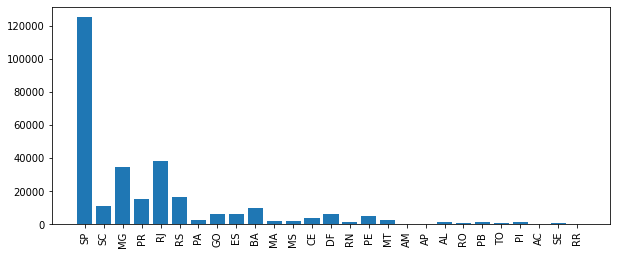

In [15]:
query = """ select  customer_state, count(customer_id) AS Num_of_Customers
from customers
group by customer_state;

 """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['customer_state', 'Num_of_Customers'])
data = df.sort_values(by = 'Num_of_Customers', ascending = False)

plt.figure(figsize = (10,4))
plt.bar(df['customer_state'], df['Num_of_Customers'])
plt.xticks(rotation = 90)
plt.show()

### Calculate the number of orders per month in 2018

In [16]:
query = """ select monthname(order_purchase_timestamp) AS months, count(order_id) from orders
where year(order_purchase_timestamp) = 2018
GROUP BY months;
 """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Months','No_of_Order'])
df

,Months,No_of_Order
0,July,18876
1,August,19536
2,February,20184
3,June,18501
4,March,21633
5,January,21807
6,May,20619
7,April,20817
8,September,48
9,October,12


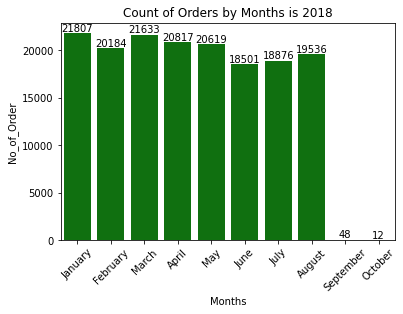

In [17]:
o = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October']

ax = sns.barplot(x = df["Months"],y =  df["No_of_Order"], data = df, order = o, color = "green")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")

plt.show()

### Find the average number of products per order, grouped by customer city 

In [18]:
query = """ WITH count_per_order AS(
select o.order_id, o.customer_id, count(ot.order_id) as ORDER_COUNT
from orders as o
JOIN order_items as ot
	on o.order_id = ot.order_id
GROUP BY o.order_id, o.customer_id)

select c.customer_city, ROUND(avg(cp.ORDER_COUNT),2) AS Count_per_Order
from customers as c
JOIN count_per_order as cp
	on c.customer_id = cp.customer_id
group by c.customer_city
order by  Count_per_Order DESC;

 """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Customer_city', 'Avg_Count_per_order'])
df.head(10)

,Customer_city,Avg_Count_per_order
0,padre carvalho,63.00
1,celso ramos,58.50
2,datas,54.00
3,candido godoi,54.00
4,matias olimpio,45.00
5,cidelandia,36.00
6,curralinho,36.00
7,picarra,36.00
8,morro de sao paulo,36.00
9,teixeira soares,36.00


### Calculate the percentage of total revenue contributed by each product category.

In [19]:
query = """ select upper(p.product_category) AS category, 
ROUND((sum(payments.payment_value) / (select sum(payment_value) from payments)) * 100, 2) AS Sales
from products as p
JOIN order_items as ot
	on p.product_id = ot.product_id
JOIN payments
	on payments.order_id = ot.order_id
GROUP BY category
ORDER BY Sales DESC; """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Category', '% of Total_Revenue'])
df.head(10)

,Category,% of Total_Revenue
0,BED TABLE BATH,96.28
1,HEALTH BEAUTY,93.18
2,COMPUTER ACCESSORIES,89.13
3,FURNITURE DECORATION,80.40
4,WATCHES PRESENT,80.35
5,SPORT LEISURE,78.26
6,HOUSEWARES,61.55
7,AUTOMOTIVE,47.91
8,GARDEN TOOLS,47.13
9,COOL STUFF,43.83


### Identify the correlation between product price and the number of times a product has been purchased.

In [20]:
import numpy as np

query = """ select products.product_category, 
count(order_items.product_id),
ROUND(avg(order_items.price), 2)
from products 
JOIN order_items
	ON products.product_id = order_items.product_id
GROUP BY products.product_category;
 """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['category', 'order_count', 'price'])
df.head(10)

,category,order_count,price
0,HEALTH BEAUTY,87030,130.16
1,sport leisure,77769,114.34
2,Cool Stuff,34164,167.36
3,computer accessories,70443,116.51
4,Watches present,53919,201.14
5,housewares,62676,90.79
6,electronics,24903,57.91
7,None,14427,112.00
8,toys,37053,117.55
9,bed table bath,100035,93.30


In [21]:
arr1 = df['order_count']
arr2 = df['price']

a = np.corrcoef([arr1, arr2])

print('The corelation between price and number of times a product has been purchased is :', a[0][-1])

The corelation between price and number of times a product has been purchased is : -0.10631514167157567


###  Calculate the total revenue generated by each seller, and rank them by revenue

In [22]:
query = """ select *, DENSE_RANK() OVER(ORDER BY Revenue DESC) AS rn
from
(select order_items.seller_id, ROUND(sum(payments.payment_value), 2) AS Revenue
from order_items
join payments
	on order_items.order_id = payments.order_id
GROUP BY order_items.seller_id) as a;
 """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Seller_id', 'Revenue', 'Rank'])
df.head(10)

,Seller_id,Revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,4564502.17,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,2773998.36,2
2,4a3ca9315b744ce9f8e9374361493884,2711207.43,3
3,1f50f920176fa81dab994f9023523100,2612280.78,4
4,53243585a1d6dc2643021fd1853d8905,2564127.72,5
5,da8622b14eb17ae2831f4ac5b9dab84a,2449973.87,6
6,4869f7a5dfa277a7dca6462dcf3b52b2,2377495.09,7
7,955fee9216a65b617aa5c0531780ce60,2126900.70,8
8,fa1c13f2614d7b5c4749cbc52fecda94,1858619.07,9
9,7e93a43ef30c4f03f38b393420bc753a,1666207.89,10


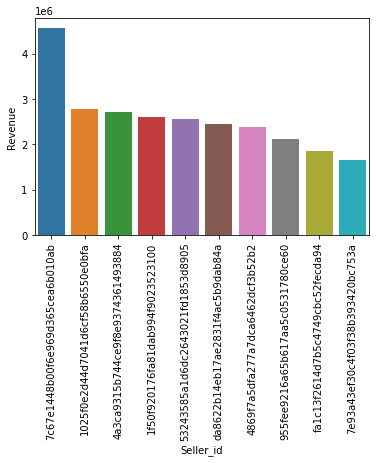

In [23]:
sns.barplot(x = 'Seller_id', y = 'Revenue', data = df.head(10))
plt.xticks(rotation = 90)
plt.show()

###  Calculate the moving average of order values for each customer over their order history

In [25]:
query = """ select customer_id, order_purchase_timestamp,payment,
avg(payment) OVER(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as Moving_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value AS payment
from payments
JOIN orders
	on payments.order_id = orders.order_id) as a;

 """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['customer_id', 'order_purchase_timestamp', 'payment', 'Moving_avg'])
df.head(10)

,customer_id,order_purchase_timestamp,payment,Moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
5,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
6,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
7,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
8,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
9,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004


###  Calculate the cumulative sales per month for each year

In [27]:
query = """ select years, months, payment, 
Round(sum(payment) OVER(order by years, months), 2) AS cumulative_sales
from 
(select year(orders.order_purchase_timestamp) as years,
monthname(orders.order_purchase_timestamp) as months,
ROUND(sum(payments.payment_value), 2) AS payment
from orders
join payments
	on orders.order_id = payments.order_id
group by years, months
order by years, months) as a;

 """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Years', 'Months', 'Payment', 'Cumulative_sales'])
df.head(10)

,Years,Months,Payment,Cumulative_sales
0,2016,December,176.58,176.58
1,2016,October,531814.32,531990.90
2,2016,September,2270.16,534261.06
3,2017,April,3760092.27,4294353.33
4,2017,August,6069566.88,10363920.21
5,2017,December,7905613.32,18269533.53
6,2017,February,2627172.09,20896705.62
7,2017,January,1246392.36,22143097.98
8,2017,July,5331446.28,27474544.26
9,2017,June,4601487.42,32076031.68


### Calculate the year-over-year growth rate of total sales

In [33]:
query = """ WITH a as
(select 
year(orders.order_purchase_timestamp) as years,
ROUND(sum(payments.payment_value), 2) AS payment
from orders
join payments
	on orders.order_id = payments.order_id
group by years
order by years)

select years, payment, ((payment - lag(payment, 1) over(order by years)) / lag(payment, 1) over(order by years)) * 100
from a;

 """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Years', 'Payment', 'Year_on_Year % growth'])
df

,Years,Payment,Year_on_Year % growth
0,2016,534261.06,NaN
1,2017,65247720.55,12112.703758
2,2018,78297867.47,20.000924


### Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase

In [34]:
query = """ WITH a as
(select customers.customer_id, 
min(orders.order_purchase_timestamp) AS First_order
from customers
join orders
	on customers.customer_id = orders.customer_id
GROUP BY customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) AS next_order
from a
join orders
	on orders.customer_id = a.customer_id
	and orders.order_purchase_timestamp > First_order
    and orders.order_purchase_timestamp < date_add(first_order, interval 18 month)
GROUP BY a.customer_id)


select 100 * (count(distinct a.customer_id)/ count(distinct b.customer_id))
from a
left join b
	on a.customer_id = b.customer_id;

 """

cur.execute(query)

data = cur.fetchall()
data

[(None,)]

### Identify the top 3 customers who spent the most money in each year 

In [37]:
query = """ select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) AS YEARS,
orders.customer_id,
ROUND(Sum(payments.payment_value), 2) AS payment,
DENSE_RANK() OVER(partition by year(orders.order_purchase_timestamp) 
ORDER BY Sum(payments.payment_value) desc) AS d_rank
from orders
join payments
	on payments.order_id = orders.order_id
GROUP BY year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3;

 """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Years', 'customer_id', 'Payment', 'Rankk'])
df

,Years,customer_id,Payment,Rankk
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,12811.95,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,12606.66,2
2,2016,4a06381959b6670756de02e07b83815f,11050.02,3
3,2017,1617b1357756262bfa56ab541c47bc16,122976.72,1
4,2017,c6e2731c5b391845f6800c97401a43a9,62363.79,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,60539.94,3
6,2018,ec5b2ba62e574342386871631fafd3fc,65473.92,1
7,2018,f48d464a0baaea338cb25f816991ab1f,62299.89,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,43284.96,3


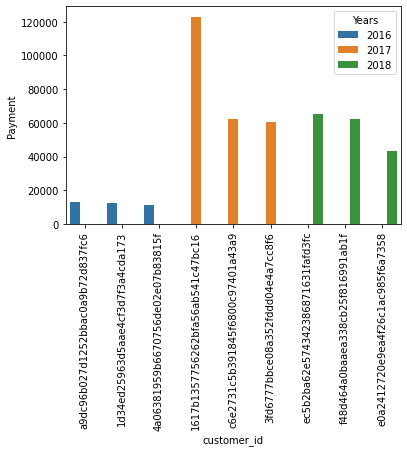

In [38]:
sns.barplot(x = "customer_id", y = "Payment", data = df, hue = "Years")
plt.xticks(rotation = 90)
plt.show()